In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

sys.path.append(os.path.join(os.getcwd(), '..'))
from dataset_utils.dataset import StudioLiveDataset, StudioLiveDataModule

/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
STUDIO_PATH = "../../dataset/studio"
LIVE_PATH = "../../dataset/live"

In [3]:
dataset = StudioLiveDataset(
    studio_dir=STUDIO_PATH,
    live_dir=LIVE_PATH,
    sr=22050,
    segment_duration=0.5,  # 0.5 second segments
    development_mode=True, 
)

print(f"Dataset loaded with {len(dataset)} segments")

Loading segments from cache: ./cache/segments_6560f0dda77b70d7ba2ec798a03e5942.pkl
Loaded 380 segments from cache
Dataset loaded with 380 segments


## Visualize segments

In [4]:
similarities = []
durations = []
pairs_info = []

for i in range(len(dataset)):
    info = dataset.get_pair_info(i)
    similarities.append(info['lyric_similarity'])
    durations.append(info['duration'])
    pairs_info.append(info)

print(f"Lyric similarity stats:")
print(f"  Mean: {np.mean(similarities):.3f}")
print(f"  Min: {np.min(similarities):.3f}")
print(f"  Max: {np.max(similarities):.3f}")
print(f"  Std: {np.std(similarities):.3f}")

print(f"\nDuration stats:")
print(f"  Mean: {np.mean(durations):.2f}s")
print(f"  Min: {np.min(durations):.2f}s")
print(f"  Max: {np.max(durations):.2f}s")

Lyric similarity stats:
  Mean: 0.639
  Min: 0.340
  Max: 1.000
  Std: 0.216

Duration stats:
  Mean: 0.50s
  Min: 0.50s
  Max: 0.50s


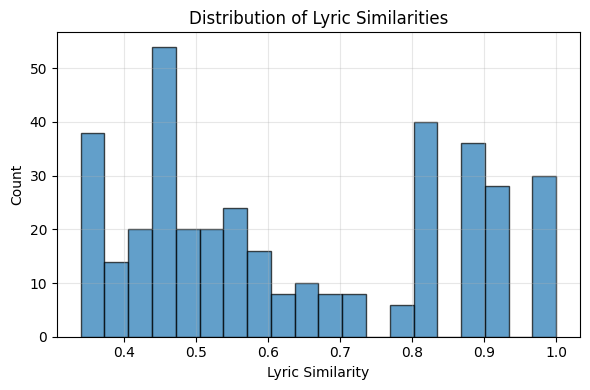

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))

ax1.hist(similarities, bins=20, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Lyric Similarity')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Lyric Similarities')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Visualize Best and Worst Alignments

In [8]:
best_idx = np.argmax(similarities)
worst_idx = np.argmin(similarities)

print(f"Best lyric similarity: {similarities[best_idx]:.3f} (segment {best_idx})")
print(f"Worst lyric similarity: {similarities[worst_idx]:.3f} (segment {worst_idx})")

# dataset[idx] returns spectrograms, not raw audio
best_spec_x, best_spec_y = dataset[best_idx]
worst_spec_x, worst_spec_y = dataset[worst_idx]

# get raw audio from the underlying pairs for playback

best_audio_x = dataset.pairs[best_idx]["studio"]
print(f"Raw audio length: {len(best_audio_x)} samples")

best_audio_y = dataset.pairs[best_idx]["live"]
print(f"\nSpectrogram shape: {best_spec_x.shape}")

worst_audio_x = dataset.pairs[worst_idx]["studio"]

worst_audio_y = dataset.pairs[worst_idx]["live"]
worst_info = dataset.get_pair_info(worst_idx)

best_info = dataset.get_pair_info(best_idx)

Best lyric similarity: 1.000 (segment 136)
Worst lyric similarity: 0.340 (segment 30)
Raw audio length: 11025 samples

Spectrogram shape: torch.Size([128, 22])


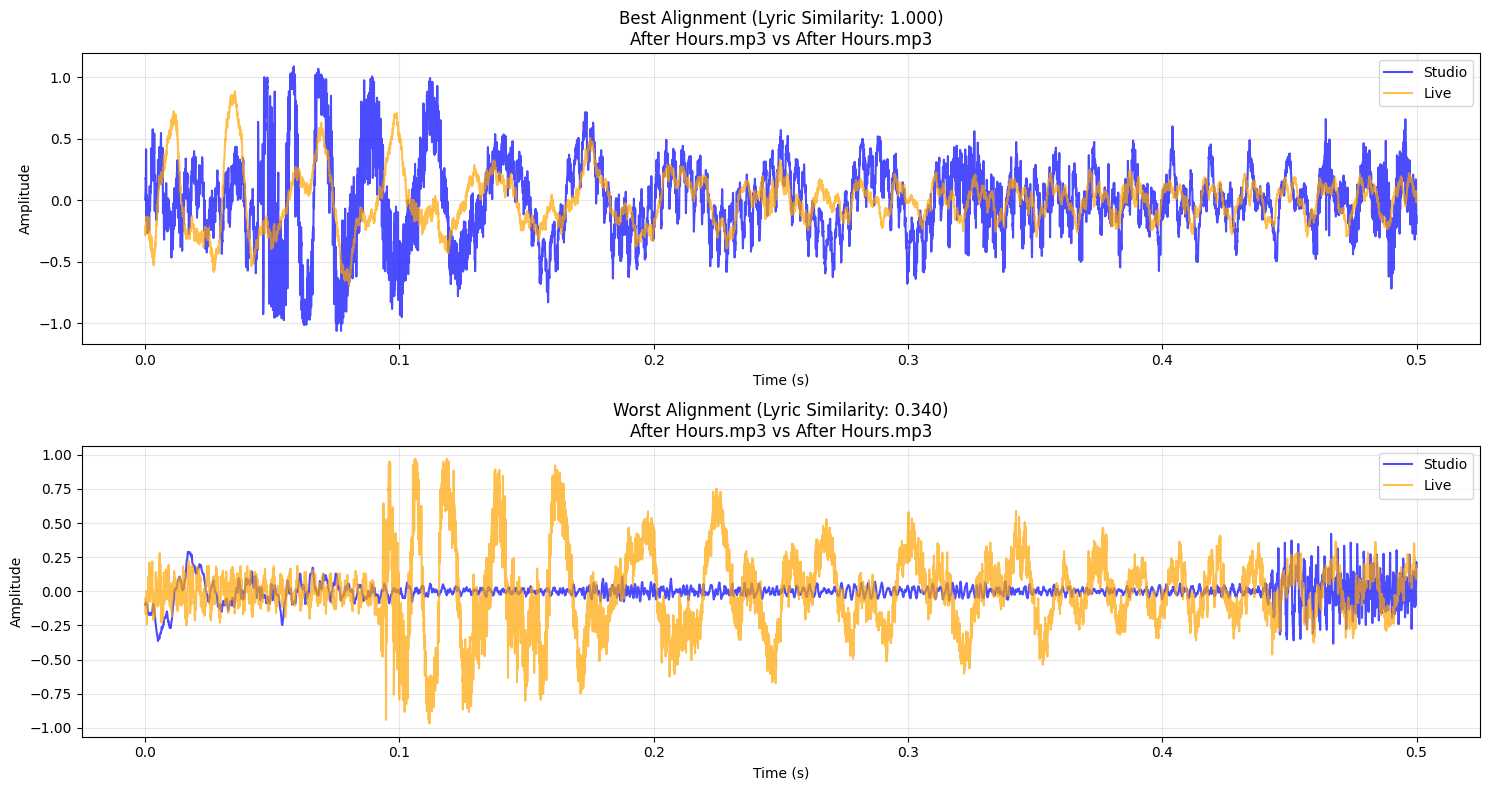

In [9]:
# --- Waveform plots (raw audio) ---
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

sr = 22050
time_best = np.arange(len(best_audio_x)) / sr
time_worst = np.arange(len(worst_audio_x)) / sr

axes[0].plot(time_best, best_audio_x, alpha=0.7, label='Studio', color='blue')
axes[0].plot(time_best[:len(best_audio_y)], best_audio_y[:len(best_audio_x)], alpha=0.7, label='Live', color='orange')
axes[0].set_title(f"Best Alignment (Lyric Similarity: {best_info['lyric_similarity']:.3f})\n{best_info['studio_name']} vs {best_info['live_name']}")
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(time_worst, worst_audio_x, alpha=0.7, label='Studio', color='blue')
axes[1].plot(time_worst[:len(worst_audio_y)], worst_audio_y[:len(worst_audio_x)], alpha=0.7, label='Live', color='orange')
axes[1].set_title(f"Worst Alignment (Lyric Similarity: {worst_info['lyric_similarity']:.3f})\n{worst_info['studio_name']} vs {worst_info['live_name']}")
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## Listen to Audio Segments

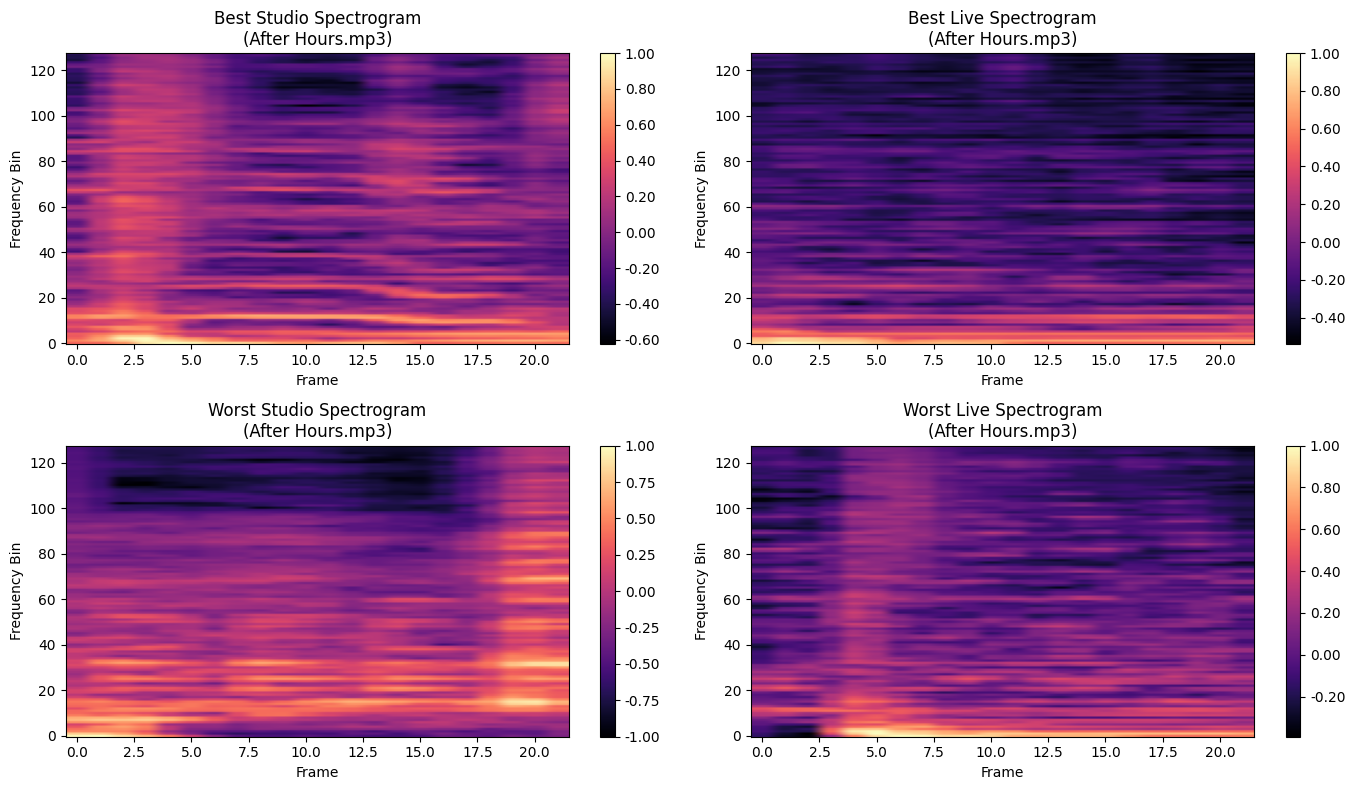

In [12]:
# --- Spectrogram plots ---
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Best alignment spectrograms
im0 = axes[0, 0].imshow(best_spec_x, aspect='auto', origin='lower', cmap='magma')
axes[0, 0].set_title(f"Best Studio Spectrogram\n({best_info['studio_name']})")
axes[0, 0].set_ylabel('Frequency Bin')
axes[0, 0].set_xlabel('Frame')
plt.colorbar(im0, ax=axes[0, 0], format="%.2f")

im1 = axes[0, 1].imshow(best_spec_y, aspect='auto', origin='lower', cmap='magma')
axes[0, 1].set_title(f"Best Live Spectrogram\n({best_info['live_name']})")
axes[0, 1].set_ylabel('Frequency Bin')
axes[0, 1].set_xlabel('Frame')
plt.colorbar(im1, ax=axes[0, 1], format="%.2f")

# Worst alignment spectrograms
im2 = axes[1, 0].imshow(worst_spec_x, aspect='auto', origin='lower', cmap='magma')
axes[1, 0].set_title(f"Worst Studio Spectrogram\n({worst_info['studio_name']})")
axes[1, 0].set_ylabel('Frequency Bin')
axes[1, 0].set_xlabel('Frame')
plt.colorbar(im2, ax=axes[1, 0], format="%.2f")

im3 = axes[1, 1].imshow(worst_spec_y, aspect='auto', origin='lower', cmap='magma')
axes[1, 1].set_title(f"Worst Live Spectrogram\n({worst_info['live_name']})")
axes[1, 1].set_ylabel('Frequency Bin')
axes[1, 1].set_xlabel('Frame')
plt.colorbar(im3, ax=axes[1, 1], format="%.2f")

plt.tight_layout()
plt.show()

## Analyze Unique Pairs

In [11]:
unique_pairs = {}
for i, info in enumerate(pairs_info):
    pair_key = (info['studio_name'], info['live_name'])
    if pair_key not in unique_pairs:
        unique_pairs[pair_key] = []
    unique_pairs[pair_key].append((i, info))

print(f"Unique studio-live pairs: {len(unique_pairs)}")
for pair_key, segments in unique_pairs.items():
    studio_name, live_name = pair_key
    avg_sim = np.mean([seg[1]['lyric_similarity'] for seg in segments])
    offset_sec = segments[0][1]['offset_sec']  
    print(f"  {studio_name} <-> {live_name}: {len(segments)} segments, avg similarity={avg_sim:.3f}, offset={offset_sec:.2f}s")

Unique studio-live pairs: 1
  After Hours.mp3 <-> After Hours.mp3: 380 segments, avg similarity=0.639, offset=-0.00s
